# Share of Search Flow

Here you will find the Prefect Flow Developed to automate scraping Google Trends

## Imports and Parameters

In [16]:
import pandas as pd
from google.oauth2 import service_account
from prefect import task, Flow, unmapped
import gspread
from pytrends.request import TrendReq
import requests
import datetime 
from time import sleep

In [2]:
GCP_CREDENTIALS = ''#your service account secret
gcp_pid = '' # Your Google Cloud Platform project_id
destination_table = '' #Your Destination Table name in GCP
#DMA dataframe dtype cast schema
dma_cast_dtype = {'data_feed': 'int64', 
                   'week_of': 'string', 
                   'geoName': 'string',
                   'geoCode': 'int64',
                   'category': 'string',
                   'keywords': 'string',
                   'value': 'int64'}
#Interest over Time dtype cast schema
iot_cast_dtype = {'data_feed' : 'int64',
                  'category': 'string',
                  'keywords': 'string'}
#GBQ DMA table schema
dma_schema = [{'name': 'data_feed', 'type': 'INTEGER'},
              {'name': 'week_of', 'type': 'DATE'},
              {'name': 'geoName', 'type': 'STRING'},
              {'name': 'geoCode', 'type': 'INTEGER'},
              {'name': 'category', 'type': 'STRING'},
              {'name': 'keywords', 'type': 'STRING'},
              {'name': 'value', 'type': 'INTEGER'}]
#GBQ Interest over time table 
iot_schema = [{'name': 'date', 'type' : 'TIMESTAMP'}, 
          {'name': 'data_feed', 'type': 'INTEGER'}, 
          {'name': 'category', 'type': 'STRING'},
          {'name': 'keywords', 'type': 'STRING'},
          {'name': 'value', 'type': 'INTEGER'}]

# Prefect Tasks

## Date

Gets date from 7 days ago using Worldclockapi since datetime.today() always returns the flow registration time. this flow was designed to run once a week

In [3]:

@task(name='get_datetime_7d')
def get_datetime_7d():
    date = requests.get('http://worldclockapi.com/api/json/pst/now').json()['currentDateTime']
    date = datetime.datetime.strptime(date.split('T')[0],'%Y-%m-%d') - datetime.timedelta(days=7)
    date = date.strftime('%Y-%m-%d')
    return date

## Google Sheets API
This task authenticates with the GSheets API using the Service Account Credentials, opens Worksheet with the passed name, and selects the first page of said Worksheet.

In [4]:
@task(name='gspread_to_dataframe',nout=2)
def gspread_to_dataframe(worksheet, credentials):
    client = gspread.service_account_from_dict(credentials)
    wks = client.open(worksheet)
    #HARDCODED SHEET OF WORKSHEET TO OPEN
    sheet = wks.sheet1
    data = sheet.get_all_values()
    headers = data.pop(0)
    keywords = headers[1:6]
    df = pd.DataFrame(data, columns=headers)
    return(df, keywords)

## Sanitize Data from Sheet
Empty cells in GSheets are read as an empty string so we overwrite them as an pd.NA value for easier processing.
We also build an the keyword array array, the category id array, and a dataframe containing the datafeed numbers and the Category Names, for our Pytrends Queries

In [5]:
@task(name='df_sanitize')    
def df_sanitize(dataframe, kw_arr):
    dataframe = dataframe.replace('', pd.NA)
    dataframe = dataframe.dropna(how='all',subset=kw_arr)
    return(dataframe)

#builds arrays where name[index] and index corresponds to query index
@task(name='build_arrs', nout=3)
def build_arrs(df):
    def kw_extract(n, dataf):
        temp = dataf.iloc[[n]]
        temp = temp.dropna(axis='columns',how='any')
        return temp.values.tolist()[0]
    cat_id_arr = df['Category ID'].replace(pd.NA, 0).to_list()
    df = df.drop(columns='Category ID')
    feed_catg = df[['Data Feed', 'Search Category']].replace(pd.NA, 'All Categories')
    df = df.drop(columns=['Data Feed', 'Search Category'])
    query_arr = [kw_extract(i,df) for i in df.index]
    return(query_arr, cat_id_arr, feed_catg)


## [Pytrends](https://github.com/GeneralMills/pytrends)

Pytrends is the Unofficial Google Trends API we use to look up our keywords. We perform 2 types of Trends API Requests: [`pytrends.interest_over_time()`](https://github.com/GeneralMills/pytrends#interest-over-time) and [`pytrends.interest_by_region()`](https://github.com/GeneralMills/pytrends#interest-by-region)

In [6]:
@task(name='pytrends_init')
def pytrends_init():
    pytrends = TrendReq(hl='en-US', tz=540, geo='US')
    return pytrends

### [Interest over Time](https://github.com/GeneralMills/pytrends#interest-over-time)


In [7]:
@task(name='gtrends_overtime')
def gtrends_overtime(q_arr, cid_arr, dataf_catg, pytrends):
    i = 0 
    while i < len(cid_arr):
        pytrends.build_payload(q_arr[i], cat=cid_arr[i], timeframe='now 7-d', gprop='')
        #first iteration creates dataframe after each result is concatenated to the end
        if i == 0: 
            df_time = pytrends.interest_over_time()
            #conditional checks to make sure Google Trends returns data else notify slack pass
            if not(df_time.empty):
                df_time['data_feed'] = dataf_catg.iloc[i][0]
                df_time['category'] = dataf_catg.iloc[i][1]
                df_time.drop(columns='isPartial', inplace=True)
                df_time.reset_index(inplace=True)
                #melt to usable format
                output = df_time.melt(id_vars=['date', 'data_feed', 'category'], var_name='keywords')
            else:
                ft_dict = {'date': [pd.NA],
                           'data_feed': [i+1],
                           'category': [dataf_catg.iloc[i][1]],
                           'keywords': ['Lack of Data'],
                           'value': [0]}
                df_time = pd.DataFrame(ft_dict)
                output = df_time
        else:
            df_time = pytrends.interest_over_time()
            #same conditional as above
            if not(df_time.empty):
                df_time['data_feed'] = dataf_catg.iloc[i][0]
                df_time['category'] = dataf_catg.iloc[i][1]
                df_time.drop(columns='isPartial', inplace=True)
                df_time.reset_index(inplace=True)
                #melt to usable format
                df_time = df_time.melt(id_vars=['date','data_feed', 'category'], var_name='keywords')
                output = pd.concat([output, df_time], ignore_index=True)
                
            else:
                ft_dict = {'date': [pd.NA],
                           'data_feed': [i+1],
                           'category': [dataf_catg.iloc[i][1]],
                           'keywords': ['Lack of Data'],
                           'value': [0]}
                df_time = pd.DataFrame(ft_dict)
                output = pd.concat([output, df_time], ignore_index=True)
           
        #arbitrary sleep
        sleep(2)
        i += 1
    output = output.astype(iot_cast_dtype)
    return output

### [Interest by Region](https://github.com/GeneralMills/pytrends#interest-by-region)

In [8]:
@task(name='gtrends_dma')
def gtrends_byregion(q_arr, cid_arr, dataf_catg, week_of, pytrends):
    i = 0 
    while i < len(cid_arr):
        pytrends.build_payload(q_arr[i], cid_arr[i], timeframe='now 7-d', gprop='')
        if i == 0:
            df_dma = pytrends.interest_by_region(resolution='DMA', inc_low_vol=True, inc_geo_code=True)
            df_dma['week_of'] = week_of
            df_dma['data_feed'] = dataf_catg.iloc[i][0]
            df_dma['category'] = dataf_catg.iloc[i][1]
            df_dma.reset_index(inplace = True)
            output = df_dma.melt(id_vars=['data_feed','week_of', 'geoName', 'geoCode', 'category'], var_name='keywords')
        else:
            df_dma = pytrends.interest_by_region(resolution='DMA', inc_low_vol=True, inc_geo_code=True)
            df_dma['week_of'] = week_of
            df_dma['data_feed'] = dataf_catg.iloc[i][0]
            df_dma['category'] = dataf_catg.iloc[i][1]
            df_dma.reset_index(inplace = True)
            df_dma = df_dma.melt(id_vars=['data_feed','week_of', 'geoName', 'geoCode', 'category'], var_name='keywords')
            output = pd.concat([output,df_dma], ignore_index=True)
        sleep(2)
        i += 1
    output = output.astype(dma_cast_dtype)
    return output

## Upload to Google Big Query

Using the `to_gbq()` pandas method 

In [9]:
#Authenticates and uploads DMA data to GBQ
@task(name='gbq_upload_dma')
def gbq_upload_dma(df, credentials, pid, dest_table):
    credential = service_account.Credentials.from_service_account_info(credentials)
    #CHANGE destination_table
    df.to_gbq(credentials=credential, if_exists='append', project_id=pid,
              destination_table=dest_table, table_schema=dma_schema)
    
#Authenticates and uploads IOT data to GBQ
@task(name='gbq_upload_iot')
def gbq_upload_iot(df, credentials, pid, dest_table):
    credential = service_account.Credentials.from_service_account_info(credentials)
    #CHANGE destination_table
    df.to_gbq(credentials=credential, if_exists='append', project_id=pid,
              destination_table=dest_table, table_schema=iot_schema)


# Prefect Flow

In [13]:
with Flow('share_of_search_flow') as flow:
    dataframe_gdata = gspread_to_dataframe('Share of Search', GCP_CREDENTIALS)
    cleaned_df = df_sanitize(*dataframe_gdata)
    arrs = build_arrs(cleaned_df)
    pytrends = pytrends_init(upstream_tasks=[arrs])
    date = get_datetime_7d()
    iot_data = gtrends_overtime(*arrs, pytrends)
    dma_data = gtrends_byregion(*arrs, date, pytrends)
    upload_iot = gbq_upload_iot(iot_data, GCP_CREDENTIALS, gcp_pid, destination_table) 
    upload_dma = gbq_upload_dma(dma_data, GCP_CREDENTIALS, gcp_pid, destination_table)


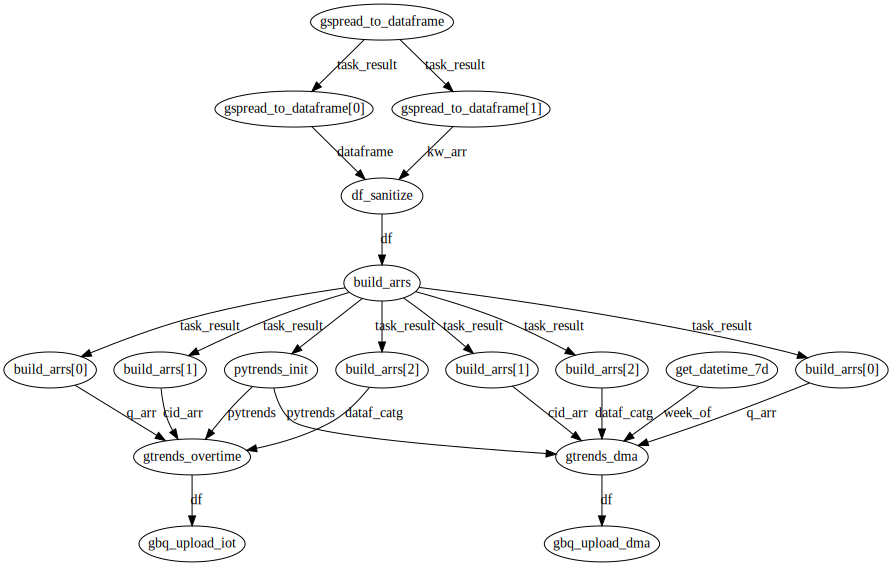

In [14]:
flow.visualize()